#Tutorial of SpeedyIBL based on Instance Based Learning Theory (IBLT)

In an attempt to increase the usage of SpeedyIBL, we hereby provide a tutorial on how to install and use the SpeedyIBL library. Specifically, we explain how to build an IBL agent, and elaborate on the meaning of associated inputs and functions. Afterwards, we present worked examples on two illustrative tasks:  Binary Choice and Navigation. It is worth noting that all the codes to run all the tasks and to replicate the results presented in the paper are available at https://github.com/DDM-Lab/SpeedyIBL. Finally, for the reproducibility purpose, we give an example on how to reproduce all the reported results using PyIBL and SpeedyIBL. In addition, we provide a Jupyter notebook file of the turorial, see https://github.com/DDM-Lab/SpeedyIBL/blob/main/tutorial_speedyibl.ipynb, for running the aforementioned tasks using SpeedyIBL. We also can run this file on Google Colab https://colab.research.google.com/github/nhatpd/SpeedyIBL/blob/main/tutorial_speedyibl.ipynb without installing Python on personal computers. 

##Installing SpeedyIBL
Note that the speedyibl library is a Python module, which is stored at PyPI (pypi.org), a repository of software for the Python programming language, see https://pypi.org/project/speedyibl/. Hence, installing SpeedyIBL is a very simple process. Indeed, one can install SpeedyIBL by simply typing at the command line:


In [ ]:
pip install speedyibl

#Importing and describing the class Agent of SpeedyIBL

After installing the library, we need to import the class Agent of SpeedyIBL by typing:

In [ ]:
from speedyibl import Agent 

We provide the descriptions of the inputs and main functions of the class Agent in the following tables.

```markdown
Inputs         | Type          | Description 
---------------|---------------|-------------------------------------------------------
efault_utility | float         | initial utility value for each instance, default = 0.1
noise          | float         | noise parameter sigma, default  = 0.25
decay          | float         |  decay paremeter d, default = 0.5
mismatchPenalty| None or float | mismatch penalty parameter, default = None (without partial matching process)
lendeque       | None or int   | maximum size of a deque for each instance that contains 
                                 timestamps or  None if unbounded, default = 250000
------------------------------------------------------------------------------------------

Inputs               | Type                      | Description 
---------------------|---------------------------|-----------------------------------------
choose               | list of options           | choose one option from the given list of options
respond              | reward                    | add the current timestamp to the instance
                                                   of the last option and this reward
prepopulate          | option, reward            | initialize time 0 for the instance of this option and reward
populate_at          | option, reward, time      | add time to the instance of this option and reward
equal_delay_feedback | reward, list of instances | update instances in the list by using this reward
instances            | no input                  | show all the instances in the memory
-------------------------------------------------------------------------------------------

```

#Using SpeedyIBL for binary choice task

From the list of inputs of the class Agent, although we need 5 inputs to create an IBL agent, by using the defaults for noise, decay, mismatchPenalty, and lendeque, we only need to pass the default_utility = 4.4. Hence we create an IBL agent for the binary choice task as follows:

In [ ]:
agent = Agent(default_utility=4.4)

We then define a list of options for the agent to choose:

In [ ]:
options = ['A','B'] # A is the safe option while B is the risky one

We are ready to make the agent choose one of the two options

In [ ]:
choice = agent.choose(options)

We now determine a reward that the agent can receive after choosing one option.

In [ ]:
import random 
if choice == 'A':
  reward = 3
elif random.random() <= 0.8:
  reward = 4
else:
  reward = 0

After choosing one option and observing the reward, we use the function respond, see the table above, to store the instance in the memory as follows:

In [ ]:
agent.respond(reward)

We have run one trial for the binary choice task, which includes choosing one option, observing the reward, storing the instance (respond). To conduct 1000 runs of 100 trials, we use two for loops as follows:

In [ ]:
import time # to calculate time
runs = 1000 # number of runs (participants)
trials = 100 # number of trials (episodes)
average_p = [] # to store average of performance (proportion of maximum reward expectation choice)
average_time = [] # to save time 
for r in range(runs):
  pmax = []
  ttime = [0]
  agent.reset() #clear the memory for a new run
  for i in range(trials):     
    start = time.time()
    choice = agent.choose(options) # choose one option from the list of two
    # determine the reward that agent can receive
    if choice == 'A':
      reward = 3
    elif random.random() <= 0.8:
      reward = 4
    else:
      reward = 0
    # store the instance
    agent.respond(reward)
    end = time.time()
    ttime.append(ttime[-1]+ end - start)
    pmax.append(choice == 'B') 
  average_p.append(pmax) # save performance of each run 
  average_time.append(ttime) # save time of each run 

We also provide the following code to plot the running time and performance of this SpeedyIBL agent

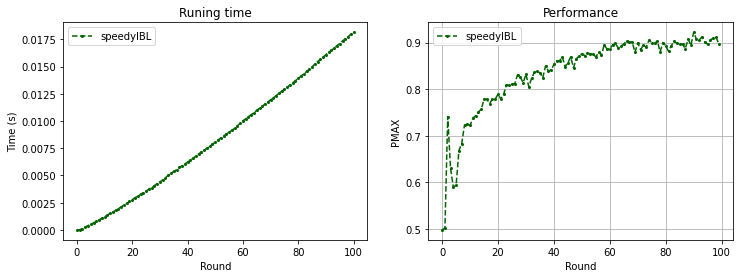

In [ ]:
import matplotlib.pyplot as plt
import numpy as np 
plt.rcParams["figure.figsize"] = (12,4)
plt.subplot(int('12'+str(1)))
plt.plot(range(trials+1), np.mean(np.asarray(average_time),axis=0), 'o-', color='darkgreen', markersize=2, linestyle='--', label='speedyIBL')
plt.xlabel('Round')
plt.ylabel('Time (s)')
plt.title('Runing time')
plt.legend()
plt.subplot(int('12'+str(2)))
plt.plot(range(trials), np.mean(np.asarray(average_p),axis=0), 'o-', color='darkgreen', markersize=2, linestyle='--', label='speedyIBL')
plt.xlabel('Round')
plt.ylabel('PMAX')
plt.title('Performance')
plt.legend()
plt.grid(True)
plt.show()

We also would like to note that the codes of both SpeedyIBL and PyIBL for generating the results of the binary choice task in the paper are available at https://github.com/DDM-Lab/SpeedyIBL/blob/main/Codes/binarychoice.py. To plot the results, please see https://github.com/DDM-Lab/SpeedyIBL/blob/main/Codes/plot_results.ipynb. 

#Using SpeedyIBL for Cooperative Navigation task

First, let us build an environment class of the navigation task. Although constructing an environment depends on specific tasks, it consists of two main functions: reset and step. The reset function sets the agents to their starting locations at beginning of each episode while the step function moves the agents to new locations and returns a new state, reward, and task status (task finished or not) after they made decisions.

In [ ]:
import numpy as np
import copy
class Environment(object):
  def __init__(self):
    #Initialize elements if the task including size of grid-world, number of agents, pixel values of agents, landmark, initial locations of agents and landmarks 
    self.GH = 16 #height of grid world
    self.GW = 16 #width of grid world
    self.NUMBER_OF_AGENTS = 3 #number of agents
    self.AGENTS = [240.0, 200.0, 150] #pixel values of [Agent1, Agent2, Agent3]
    self.LANDMARKS = [40, 50, 60] #pixel values of landmarks
    self.AGENTS_X = [0, self.GW-1, 0] #x-coordinates of initial locations of agents
    self.AGENTS_Y = [0, 0, self.GH-1]  #y-coordinates of initial locations of agents
    MID = 8
    self.LANDMARK_LOCATIONS = [(MID-2,MID-2),(MID+1,MID-2),(MID-2, MID+1)] #locations of landmarks
    self.ACTIONS = 4 # move up, down, left, righ
    
  def reset(self):
    # '''
    # Reset everything. 
    # '''
    self.s_t = np.zeros([self.GH,self.GW], dtype=np.float64) #create an array that represents states of the grid-world 
    # Agents and landmarks are initialised:
    # Agent x and y positions can be set in the following lists.
    self.agents_x = copy.deepcopy(self.AGENTS_X)
    self.agents_y = copy.deepcopy(self.AGENTS_Y)
    self.agent_status= [False for i in range(self.NUMBER_OF_AGENTS)]
    #Set pixel values of agents
    for i in range(self.NUMBER_OF_AGENTS):
        self.s_t[self.agents_y[i]][self.agents_x[i]] += self.AGENTS[i]
    #Initialize the landmarks in the environment
    for l,p in zip(self.LANDMARK_LOCATIONS,self.LANDMARKS):
      self.s_t[l[1]][l[0]] = p
    self.reached_landmarks = []
    return self.s_t
  def step(self, actions):
  # '''
  # Change environment state based on actions.
  # :param actions: List of integers providing actions for each agent
  # '''
    #Move agents according to actions.
    for i in range(self.NUMBER_OF_AGENTS):
      if not self.agent_status[i]:
        dx, dy = self.getDelta(actions[i])
        targetx = self.agents_x[i] + dx
        targety = self.agents_y[i] + dy
        if self.noCollision(targetx, targety):
          self.s_t[self.agents_y[i]][self.agents_x[i]] -= self.AGENTS[i]
          self.s_t[targety][targetx] += self.AGENTS[i]
          self.agents_x[i] = targetx
          self.agents_y[i] = targety
          if (targetx,targety) in self.LANDMARK_LOCATIONS:
            self.agent_status[i] = True
            if (targetx,targety) not in self.reached_landmarks:
              self.reached_landmarks.append((targetx,targety))
    terminal = sum(self.agent_status) == 3
    reward = len(self.reached_landmarks)
    return self.s_t, reward, terminal 

  def getDelta(self, action):
    # '''
    # Determine the direction that the agent should take based upon the action selected. The actions are: 'Up':0, 'Right':1, 'Down':2, 'Left':3, :param action: int
    # '''
    if action == 0:
      return 0, -1
    elif action == 1:
      return 1, 0    
    elif action == 2:
      return 0, 1    
    elif action == 3:
      return -1, 0
    elif action == 4:
      return 0, 0 
  def noCollision(self, x, y):
    # '''
    # Checks if x, y coordinate is currently empty 
    # :param x: Int, x coordinate
    # :param y: Int, y coordinate
    # '''
    if x < 0 or x >= self.GW or\
      y < 0 or y >= self.GH or\
      self.s_t[y][x] in self.AGENTS:
      return False
    else:
      return True

Now, we can call the environment and reset it as follows:

In [ ]:
env = Environment()
s = env.reset()

Like the binary choice task, we define three agents with default\_utility=2.5 ans save them in a list agents:

In [ ]:
number_agents = 3
agents = []
episode_history = {}
for i in range(number_agents): 
  agents.append(Agent(default_utility=2.5))
  episode_history[i] = []

Here, we have used a dictionary episode\_history to save information of each episode that we will use for the delay feedback mechanism.  Next, we create a list of options

In [ ]:
s_hash = hash(s.tobytes())
options = [(s_hash, a) for a in range(env.ACTIONS)]

Here we have used the hash function to convert an array into a hashable object used as a key in a Python dictionary. Now we make the agents choose their options and save instances.

In [ ]:
actions = [4,4,4]
for i in range(number_agents):
  if not env.agent_status[i]:
    option = agents[i].choose(options)
    actions[i] = option[1]
    agents[i].respond(0)
    episode_history[i].append((option[0],option[1],0,agents[i].t))


After choosing actions, the locations of the agents are updated in the environment by the step function:

In [ ]:
s, reward, t = env.step(actions)

When the agents finish the task (reach landmarks, i.e., t = True) or they reach the maximum number of steps, we update outcomes of previous instances by an equal delay feedback mechanism.

In [ ]:
for i in range(number_agents):
  agents[i].equal_delay_feedback(reward, episode_history[i])

In order to run 100 times of 100 episodes with 2500 steps, we use three for loops below.

In [ ]:
import time # to calculate time
runs = 100 # number of runs (participants)
trials = 100 # number of trials (episodes)
steps = 2500 # number of steps 
average_p = [] # to store average of performance (proportion of maximum reward expectation choice)
average_time = [] # to save time 

for r in range(runs):
  preward = []
  ttime = [0]
  #clear the memory for a new run
  for i in range(number_agents): 
    agents[i].reset()
  episode_history[i] = []
  for e in range(trials):     
    start = time.time()
    s = env.reset()
    # clear the previous episode
    for i in range(number_agents): 
      episode_history[i] = []
    for j in range(steps):
      s_hash = hash(s.tobytes())
      options = [(s_hash, a) for a in range(env.ACTIONS)]
      # choose one option from the list
      actions = [4,4,4]
      for i in range(number_agents):
        if not env.agent_status[i]:
          option = agents[i].choose(options)
          actions[i] = option[1]
          agents[i].respond(0)
          episode_history[i].append((option[0],option[1],0,agents[i].t)) # save information
      s, reward, t = env.step(actions)
      if t or j == steps-1:
        for i in range(number_agents):
          agents[i].equal_delay_feedback(reward, episode_history[i])
        break 
    end = time.time()
    ttime.append(ttime[-1]+ end - start)
    preward.append(reward) 
  average_p.append(preward) # save performance of each run 
  average_time.append(ttime) # save time of each run 

We can use the same source code in the binary choice task to plot the results. We would like to remark that we created a Python module \texttt{vitenv} containing all the environment in the paper, which is available at https://pypi.org/project/vitenv/. Codes of the environments of other tasks and this tutorial also available at our Github link. 

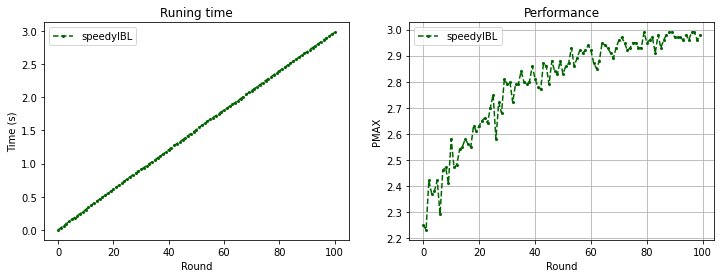

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,4)
plt.subplot(int('12'+str(1)))
plt.plot(range(trials+1), np.mean(np.asarray(average_time),axis=0), 'o-', color='darkgreen', markersize=2, linestyle='--', label='speedyIBL')
plt.xlabel('Round')
plt.ylabel('Time (s)')
plt.title('Runing time')
plt.legend()
plt.subplot(int('12'+str(2)))
plt.plot(range(trials), np.mean(np.asarray(average_p),axis=0), 'o-', color='darkgreen', markersize=2, linestyle='--', label='speedyIBL')
plt.xlabel('Round')
plt.ylabel('PMAX')
plt.title('Performance')
plt.legend()
plt.grid(True)
plt.show()

#Reproducing Results

All the results can be reproduced by running corresponding scripts for each task under folder **Codes**. In particular, to run the tasks with SpeedyIBL and PyIBL simply execute the following commands and the experiment will start.

##Binary Choice Task
```markdown
python3 binarychoice.py --method [name]
```

With argument [name] is replaced by: libl for SpeedyIBL and ibl for PyIBL.

##Insider Attack Game
```markdown
python3 insider_attack_speedyIBL.py # to run SpeedyIBL
python3 insider.py # to run PyIBL
```

##Minimap
```markdown
python3 minimap.py --type [name]
```

With argument [name] is replaced by: libl for SpeedyIBL and ibl for PyIBL. 

##MisPac-man
```markdown
python3 mispacman.py --type [name]
```

With argument [name] is replaced by: libl for SpeedyIBL and ibl for PyIBL. 

##Fireman
```markdown
python3 fireman.py --type [name]
```

With argument [name] is replaced by: libl for SpeedyIBL and ibl for PyIBL. 

##Cooperative Navigation
```markdown
python3 navigation.py --type [name]
```

With argument [name] is replaced by: libl for SpeedyIBL and ibl for PyIBL. 